In [3]:

from langchain.chat_models import init_chat_model
llm = init_chat_model("ollama:llama3.2")

In [4]:
import os

os.environ["TAVILY_API_KEY"] = "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"

In [6]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = InMemorySaver()
graph = graph_builder.compile(checkpointer=memory)

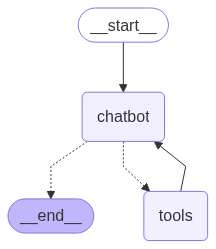

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (7175ccde-60e6-40cd-b9db-75a911fe5c80)
 Call ID: 7175ccde-60e6-40cd-b9db-75a911fe5c80
  Args:
    end_date: None
    exclude_domains: None
    include_domains: None
    include_favicon: False
    include_images: True
    query: LangGraph research
    search_depth: advanced
    start_date: None
    topic: None
================================= Tool Message =================================
Name: tavily_search

{"query": "LangGraph research", "follow_up_questions": null, "answer": null, "images": ["https://miro.medium.com/v2/resize:fit:1358/1*43hQNL-2OYN-ayl8rcbULQ.png", "https://www.marktechpost.com/wp-content/uploads/2024/01/Blog-Banner-5.png", "https://torch.classcat.com/wp-content/uploads/2025/05/lang_graph_logo.png", "https://admin

In [9]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================
Tool Calls:
  tavily_search (4d08696d-9104-4a93-8fd8-893506500282)
 Call ID: 4d08696d-9104-4a93-8fd8-893506500282
  Args:
    end_date: None
    exclude_domains: None
    include_domains: None
    include_favicon: False
    include_images: True
    query: building an autonomous agent with LangGraph
    search_depth: advanced
    start_date: None
    time_range: None
    topic: None
================================= Tool Message =================================
Name: tavily_search

{"query": "building an autonomous agent with LangGraph", "follow_up_questions": null, "answer": null, "images": ["https://www.solulab.com/wp-content/uploads/2024/11/Build-AI-Agent-with-LangGraph-1536x853.jpg", "https://i.ytimg.com/vi/nNfi9H4mFFE/maxresdefault.jpg", "https://opengraph.

In [10]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(
        state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
-----------------------------------------

In [11]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08f936-1e1d-6f9d-8006-626ba8b9815d'}}


In [12]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search (4d08696d-9104-4a93-8fd8-893506500282)
 Call ID: 4d08696d-9104-4a93-8fd8-893506500282
  Args:
    end_date: None
    exclude_domains: None
    include_domains: None
    include_favicon: False
    include_images: True
    query: building an autonomous agent with LangGraph
    search_depth: advanced
    start_date: None
    time_range: None
    topic: None
================================= Tool Message =================================
Name: tavily_search

{"query": "building an autonomous agent with LangGraph", "follow_up_questions": null, "answer": null, "images": ["https://www.solulab.com/wp-content/uploads/2024/11/Build-AI-Agent-with-LangGraph-1536x853.jpg", "https://i.ytimg.com/vi/nNfi9H4mFFE/maxresdefault.jpg", "https://opengraph.githubassets.com/f9056f2d1c3af5edf54369123097b9141608897120b95ff1f92875ba0854cb53/PacktPublishing/Building-Autonomous-AI-Agents-with-LangGraph", "h